In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display

In [3]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2020-12-15-independent-small-regen-1/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
56,2,independent,53333,1,0,zipf,0,6,sequential_frontier,NaN,NaN,1,8571,0,14669399,0,90320
13,2,independent,53333,1,0,zipf,0,4,mpi_priority_frontier,2.0,60.0,2,13440,0,6264788,0,90320
40,5,independent,88333,1,0,zipf,0,4,mpi_priority_frontier_simd,2.0,60.0,2,16837,0,12045561,0,150966
83,3,independent,65000,1,0,zipf,0,9,mpi_priority_frontier,32.0,60.0,32,15817,0,748770,0,110552
60,1,independent,41666,1,0,zipf,0,0,mpi_priority_frontier_simd,16.0,60.0,16,6101,0,513758,0,70326


0.23894491854150504


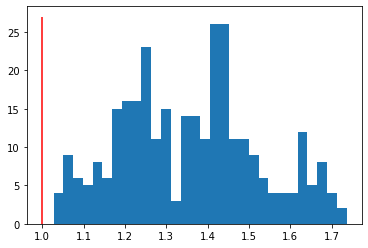

In [14]:
indexed_benchmark_results = benchmark_results.set_index(['generation_config_i', 'diff_program', 'repetition_i', 'mpi_procs'])


temp = indexed_benchmark_results['micros_until_len'].unstack('diff_program')
print((temp.sequential_frontier_simd < temp.sequential_frontier).mean())

hist_values = temp.sequential_frontier / temp.sequential_frontier_simd
#hist_values = hist_values[(hist_values < 50) & (temp.sequential > 1000)]
plt.vlines(1, 0, 27, colors=['Red'])
plt.hist(hist_values, bins=30);

mpi_priority_frontier independent:
0.6585365853658537
mpi_no_master_frontier independent:
1.0
sequential_frontier independent:
1.0


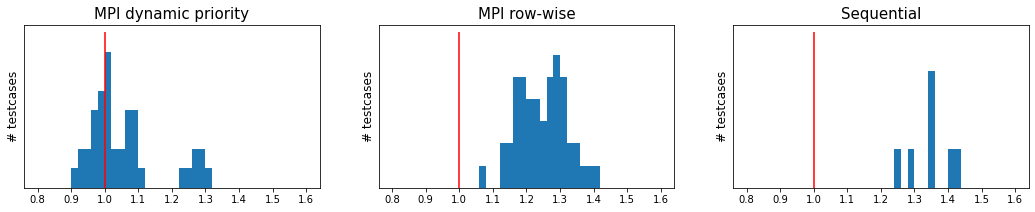

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3), sharex=False, sharey=False)
input_strategy = 'independent'
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier', 'sequential_frontier']):

        if diff_program == 'mpi_priority_frontier':
            rep_max = 19
        else:
            rep_max = 49

        no_simd = benchmark_results[(benchmark_results['diff_program'] == diff_program)].copy()
        no_simd['mpi_procs'] = no_simd['mpi_procs'].fillna('sequential')
        no_simd = no_simd.groupby(['generation_config_i', 'mpi_procs']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        simd = benchmark_results[(benchmark_results['diff_program'] == diff_program + "_simd")].copy()
        simd['mpi_procs'] = simd['mpi_procs'].fillna('sequential')
        simd = simd.groupby(['generation_config_i', 'mpi_procs']).agg({
            'repetition_i': 'max',
            'micros_until_len': 'median',
        })

        if diff_program != 'sequential_frontier':
            confidence_filter = (no_simd['repetition_i'] != rep_max) & (simd ['repetition_i'] != rep_max)     # exclude values with lower confidence

            no_simd = no_simd[confidence_filter]['micros_until_len']
            simd = simd[confidence_filter]['micros_until_len']
        else:
            no_simd = no_simd['micros_until_len']
            simd = simd['micros_until_len']

        print(diff_program + " " + input_strategy + ":")
        print((simd < no_simd).mean())

        hist_values = no_simd / simd
        #hist_values = hist_values[(hist_values < 50) & (temp.sequential > 1000)]
        
        if diff_program == 'mpi_priority_frontier':
            hist_max = 8
            title_name = "MPI dynamic priority"
        else:
            if diff_program == 'mpi_no_master_frontier':
                hist_max = 7
                title_name = "MPI row-wise"
            else:
                hist_max = 4
                title_name = "Sequential"

        this_ax = ax[diff_program_i]

        this_ax.set_title(f'{title_name}', fontsize=15)
        this_ax.vlines(1, 0, hist_max, colors=['Red'])
        this_ax.hist(hist_values, bins=40, range=(0.8, 1.6));
        this_ax.set_yticks([])
        this_ax.set_ylabel('# testcases', fontsize=12)

#fig.savefig("/mnt/c/Users/Lowis/Downloads/independent_1x3_simd_hists.png", dpi=400, transparent=True)